In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def split_data(data):
    train_mask = (data.index < "2009")
    train = data[train_mask].cases
    test_mask = (data.index > "2009")
    test = data[test_mask].cases
    return train, test

In [3]:
weekly_df = pd.read_csv("dengue-cases.csv",index_col=False)
weekly_df = weekly_df.set_index('date')
# weekly_df = weekly_df.iloc[209:]
weekly_df.index = pd.DatetimeIndex(weekly_df.index)
train_test_mask = weekly_df.index >= "2006"
train_test = weekly_df[train_test_mask].cases
train_mask = (weekly_df.index >= "2006") & (weekly_df.index < "2011")
TRAIN = weekly_df[train_mask].cases
test_mask = (weekly_df.index > "2011")
TEST = weekly_df[test_mask].cases

In [4]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,4000,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\theta\,(w_{i}\cdot x_{i}) = \frac{1}{1\,+\,e^{-\sum_{i=0}^{n} w_{i} x_{i}}}$$

$$Seasonal\,Part =\,\cos^2(\dfrac{\pi}{52}\,(x + c)) + k$$

$$\log cases = \log pop. + \log\,\theta(w\cdot x) \,+ Seasonal\,Part$$

In [18]:
LAG = 26
W_CASE = LAG + 1
W_POP = 1
W_SEASON = 2
BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

def guess(w,x_week,y_case):
    
    def season(w,x_week):
        pi = np.math.pi
        coeff = pi/52.
        inside = (coeff*x_week) - (coeff*w[-2])
        cosine_sq = np.math.cos(inside)**2
        score = cosine_sq + w[-3]
        return expit(score)

    def theta(w,y_case):
        pad_y = np.concatenate(([1],np.array(y_case)))
        score = np.dot(w[:-1],pad_y)
#         print "score",score
        return expit(score)

    return np.log(theta(w,y_case)+ 1e-5) + np.log(season(w,x_week)+1e-5) + w[-1] # w[-3] + season

def cost(w):
    ret = 0
    for week_no in range(len(TRAIN)-W_CASE):
        real_case = TRAIN[week_no+W_CASE]+ 1
#         print "real",real_case
        predicted_case = np.exp(guess(w,week_no,TRAIN[week_no:week_no+LAG]))
#         print "pred",predicted_case
#         sigma_sq = (real_case + 1)**2
        ret += ((real_case - predicted_case)**2)#/float(sigma_sq)
#     print ret/float(len(TRAIN))
    return ret/float(len(TRAIN))

pop_starter = np.log(3000.)
seasonality_starters = [0,26] 
arr = np.array([0.]*W_CASE) 
# arr = np.append(arr,seasonality_starters)
arr = np.append(arr,pop_starter)
w = minimize(cost,arr)


In [20]:
print w.fun
w.x

548215.542647


array([  1.03505550e+02,  -1.24929886e+00,   2.13729263e+00,
         6.98348025e-01,  -1.13769435e+00,   9.49527718e-02,
        -1.36352873e+00,   7.83952705e-01,  -3.39051615e-01,
         5.84691656e-01,  -1.98158739e-01,  -2.06141049e-01,
         1.37570144e+00,  -1.09459202e+00,   1.13868878e+00,
        -1.13695514e+00,  -1.08270801e+00,  -1.48783033e-01,
        -4.80656336e-01,   2.25050555e+00,   4.78822293e-02,
        -2.79395343e-01,   6.06828374e-01,  -1.45403165e+00,
         1.46012993e+00,  -3.93899846e+00,   3.73736916e+00,
         1.07900218e+01])

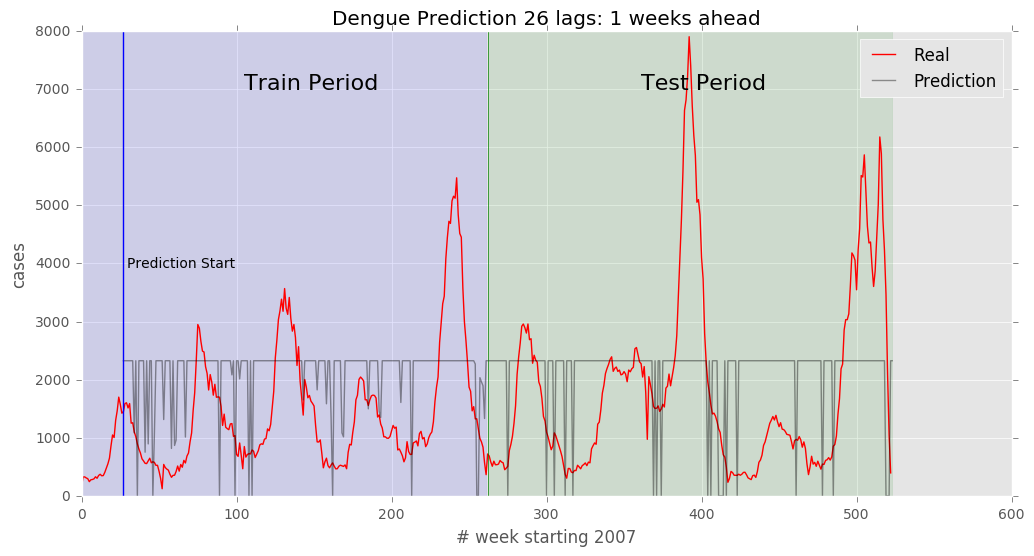

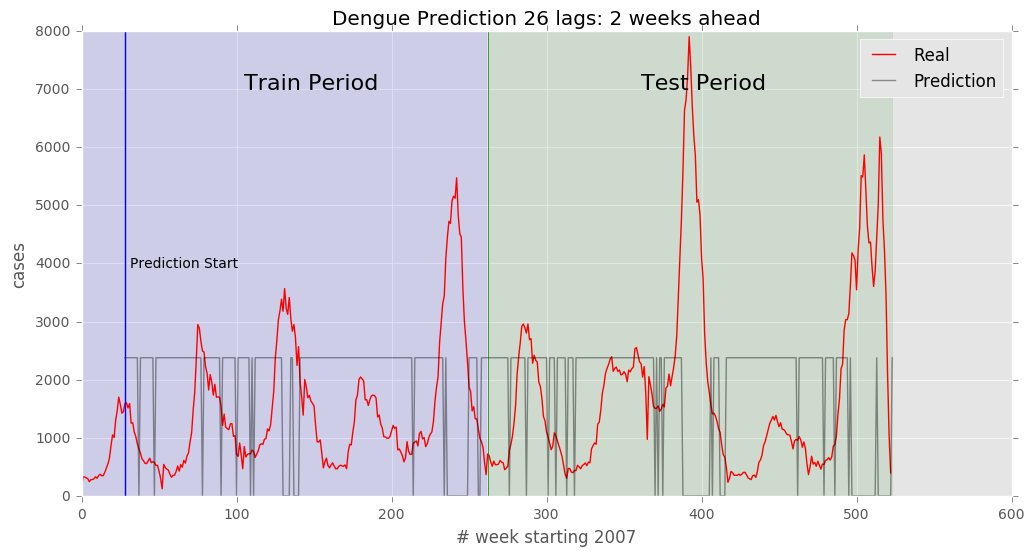

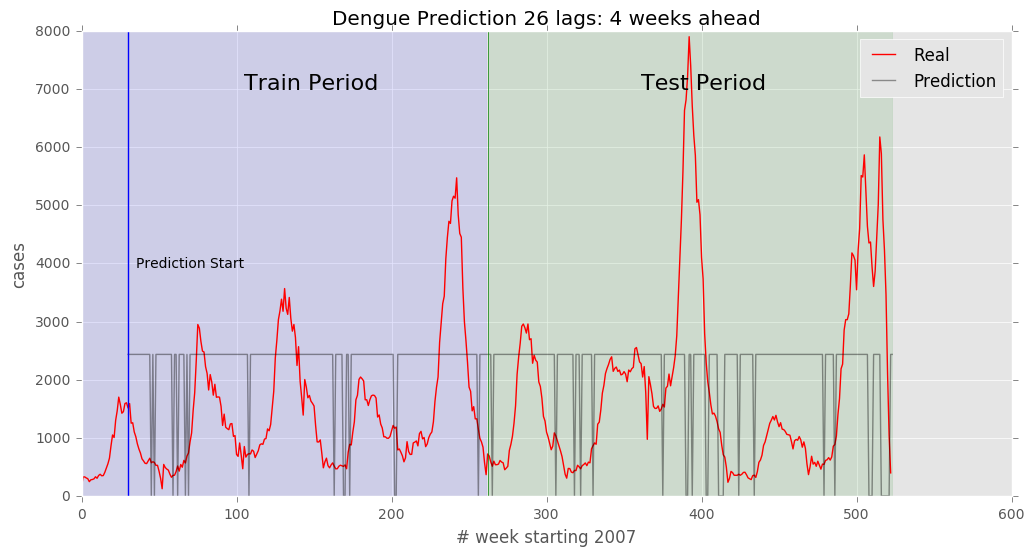

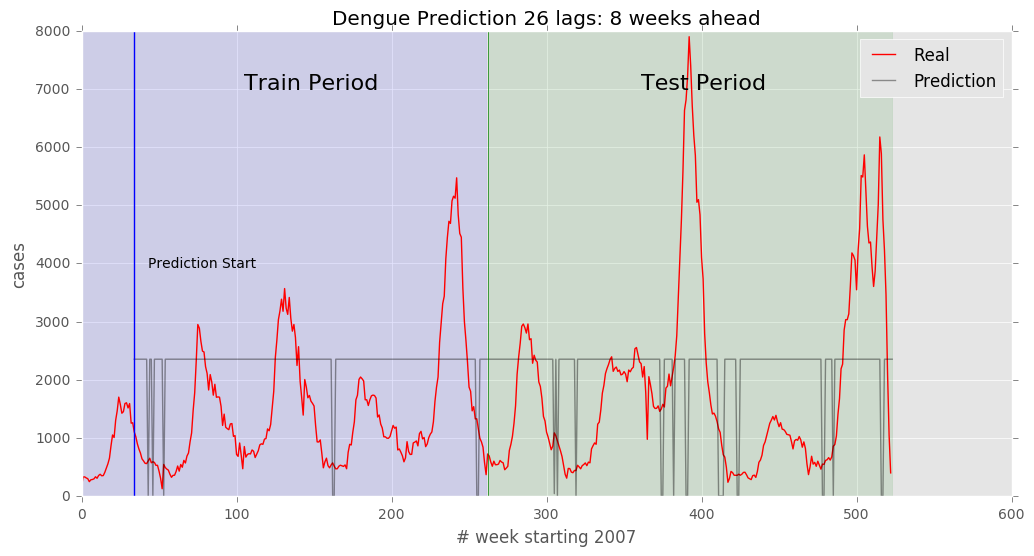

In [21]:
NWEEKS = 26
train = TRAIN
nweek_to_predict = [1,2,4,8]

def n_week_ahead(array_x,weeks_ahead):
    
    theta = 0
    arr = np.array(array_x)
    for week_no in range(weeks_ahead):
        theta = np.exp(guess(w.x,week_no,arr))
        arr = np.append(arr[1:],theta)
    return theta

all_predictions = []
for i in nweek_to_predict:
    N = NWEEKS + (i - 1)
    tmp = []
    for j in range(len(train_test)-N):
        initial_arr = train_test[j:j+NWEEKS]
        tmp.append(n_week_ahead(initial_arr,i))
    
    to_start = [0]*(NWEEKS+i)
    zeros_st = np.concatenate((to_start,tmp))
    all_predictions.append(zeros_st)
    title = 'Dengue Prediction %d lags: %d weeks ahead'%(NWEEKS,i)
    make_line(NWEEKS+i,train_test,tmp,title,"# week starting 2007","cases")
    plt.axvspan(0, len(train), color='blue', alpha=0.1)
    plt.text((len(train)/2)-25,7000,'Train Period',size=16)
    plt.axvline(len(train)+1,linewidth=0.5, color='green')
    plt.text(len(train)+100,7000,'Test Period',size=16)
    plt.axvspan(len(train)+1, len(train_test), color='green', alpha=0.1)
#     plt.show()
        

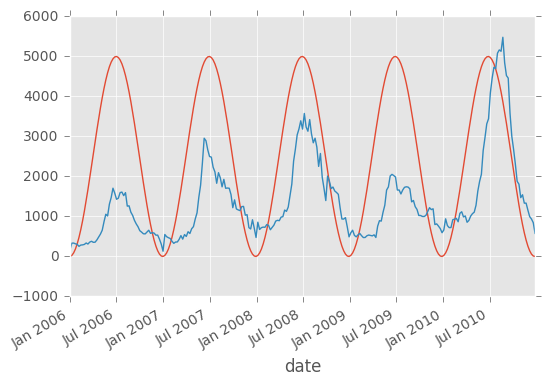

In [38]:
def season(x_week):
    pi = np.math.pi
    coeff = pi/52.
    inside = (coeff*x_week) - (coeff*25.8)
    cosine_sq = np.math.cos(inside)**2
    return 5000*cosine_sq - 6.3
    

ys = [season(i) for i in range(len(TRAIN))]
plt.plot(TRAIN.index,ys)
TRAIN.plot()